In [1]:

import numpy as np
import torch
from utils.utils_dataset import prepare_non_iid_federated_streaming_dataset
import os
from utils.utils_train import train_supervised, train_models_in_threads
from utils.utils_plots import plot_first_feature_combinations, plot_first_feature_combinations, plot_clients_and_federated_model, visualize_clients_data, plot_results_acc
import torch


In [2]:
from model.eFedG import eFedG
from model.clustering_operations import ClusteringOps
from model.removal_mechanism import RemovalMechanism 
from model.merging_mechanism import MergingMechanism
from model.math_operations import MathOps
from model.consequence_operations import ConsequenceOps
from model.model_operations import ModelOps
from model.federated_operations import FederalOps
#This is needed for debugging

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
torch.set_num_threads(os.cpu_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

PyTorch Version: 2.1.2
CUDA Version: 11.8


In [3]:
from scipy.spatial.distance import cdist
def predict_clusters(X, centers):
    distances = cdist(X, centers, metric='euclidean')
    return np.argmin(distances, axis=1)

In [4]:
import numpy as np
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score

def determine_cluster_labels(y_true, cluster_assignments):
    cluster_labels = {}
    for cluster in np.unique(cluster_assignments):
        cluster_indices = cluster_assignments == cluster
        most_common_label = Counter(y_true[cluster_indices]).most_common(1)[0][0]
        cluster_labels[cluster] = most_common_label
    return cluster_labels

def remap_assignments(assignments, cluster_labels):
    remapped_labels = np.array([cluster_labels[cluster] for cluster in assignments])
    return remapped_labels

def clustering_metrics(X_test, y_test, assignments):
    metrics = {}
    
    metrics['ARI'] = adjusted_rand_score(y_test, assignments)
    print("ARI:", metrics['ARI'])

    metrics['NMI'] = normalized_mutual_info_score(y_test, assignments)
    print("NMI:", metrics['NMI'])

    metrics['ACC'] = accuracy_score(y_test, assignments)
    print("ACC:", metrics['ACC'])

    return metrics

In [ ]:
import time
import torch

def run_federated_simulation(rounds, num_clients, local_model_params, federated_model_params, train_loaders_by_round, test_dataset, test_loader, debug_flag, 
                             profiler_flag, name=None, flag_axis=True, flag_plot=False, flag_legend=True):

    start_time = time.time()
    federated_model = eFedG(**federated_model_params) 
    local_models = [eFedG(**local_model_params) for _ in range(num_clients)]  
    round_results = []

    for round in range(rounds):
        print(f"Round {round + 1} starting...")

        round_loaders = [train_loaders_by_round[client_idx][round] for client_idx in range(num_clients)]
        
        if len(local_models) > 1:
            local_models = train_models_in_threads(local_models, round_loaders, debug_flag)
        else:
            local_models = train_supervised(local_models[0], round_loaders[0], index=1, round=round, debug_flag=debug_flag)
            local_models = [local_models]  #
        
        federated_model.__init__(**federated_model_params)
        federated_model.set_debugging_flag(debug_flag)
        
        for client_model in local_models:
            #client_model.federal_agent.federated_merging()
            federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n, 0)
        federated_model.federal_agent.federated_merging()

        if debug_flag in (1, 8):
            fig = plot_first_feature_combinations((X, y), model=federated_model, num_sigma=2, N_max=federated_model.kappa_n, flag_unlabeled=(debug_flag == 8), 
                                                  flag_axis=True)
            if debug_flag == 8:
                folder = ".Images/Clustering/Batch"
                os.makedirs(folder, exist_ok=True)

                fig.savefig(f".Images/Clustering/Batch/clustering_round{round}_0_merge.svg", bbox_inches='tight')
                fig.savefig(f".Images/Clustering/Batch/clustering_round{round}_0_merge.png", bbox_inches='tight')
                fig.savefig(f".Images/Clustering/Batch/clustering_round{round}_0_merge.pdf", bbox_inches='tight')

        if flag_plot:
            dataset_list = [(train_loader[round].dataset.tensors[0].cpu().numpy(), train_loader[round].dataset.tensors[1].cpu().numpy()) 
                            for train_loader in train_loaders_by_round]
            main_fig, legend_fig = plot_clients_and_federated_model(dataset_list, local_models, federated_model, 
                                                                    N_max=federated_model.kappa_n, flag_axis=flag_axis,
                                                                    round_num=round, flag_legend=flag_legend)

            folder = ".Images/Streaming"
            os.makedirs(folder, exist_ok=True)

            main_fig.savefig(f".Images/Streaming/streaming_{name}_{round}.svg", bbox_inches='tight')
            main_fig.savefig(f".Images/Streaming/streaming_{name}_{round}.png", bbox_inches='tight')
            main_fig.savefig(f".Images/Streaming/streaming_{name}_{round}.pdf", bbox_inches='tight')

            
        num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).cpu().numpy()
        print(f"Number of clusters in federated model: {num_federated_clusters}")
        X_test_tensor, y_test_tensor = test_dataset.tensors

        X_test_tensor, y_test_tensor = test_dataset.tensors
        X_test_numpy, y_test_numpy  = X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()
        final_centers = federated_model.mu[:federated_model.c].detach().cpu().numpy()
        _, _, test_assignments = federated_model.forward( X_test_tensor.to(federated_model.device))

        cluster_labels = determine_cluster_labels(y_test_numpy, test_assignments)
        mapped_assignments = remap_assignments(test_assignments.detach().cpu().numpy(), cluster_labels)
        metrics = clustering_metrics(X_test_numpy, y_test_numpy, mapped_assignments)
        print(metrics)

        if flag_plot:
            fig = visualize_clients_data( train_loaders_by_round, num_clients, federated_model, 1, metrics, colormap="tab10", flag_axis=flag_axis)

        for client_model in local_models:
            client_model.__init__(**local_model_params)
            client_model.set_debugging_flag(debug_flag)
            client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n, 0)
            #client_model.n /= num_clients
            #client_model.S /= num_clients 
            #client_model.n_glo/= num_clients
            #client_model.S_glo/= num_clients
            
            # Save results for the current round
            round_results.append({
                "round": round + 1,
                "num_clusters": num_federated_clusters,
                "metrics": metrics,
                "final_centers": final_centers,
                "test_assignments": mapped_assignments,
                "cluster_labels": cluster_labels,
            })


    federated_model.federal_agent.remove_irrelevant_clusters()
    times = time.time() - start_time
    print(f"Time: {times}")
    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).cpu().numpy()

    print(f"Number of clusters in federated model: {num_federated_clusters}")
    X_test_tensor, y_test_tensor = test_dataset.tensors

    X_test_tensor, y_test_tensor = test_dataset.tensors
    X_test_numpy, y_test_numpy  = X_test_tensor.detach().cpu().numpy(), y_test_tensor.detach().cpu().numpy()
    final_centers = federated_model.mu[:federated_model.c].detach().cpu().numpy()
    _, _, test_assignments = federated_model.forward( X_test_tensor.to(federated_model.device))

    cluster_labels = determine_cluster_labels(y_test_numpy, test_assignments)
    mapped_assignments = remap_assignments(test_assignments.detach().cpu().numpy(), cluster_labels)
    metrics = clustering_metrics(X_test_numpy, y_test_numpy, mapped_assignments)
    
    #if flag_plot:
    fig = visualize_clients_data( train_loaders_by_round, num_clients, federated_model, 1, metrics, colormap="tab10", flag_axis=flag_axis)
    fig.savefig(f".Images/Streaming/streaming_{name}_data.pdf", bbox_inches='tight')
    fig.savefig(f".Images/Streaming/streaming_{name}_data.svg", bbox_inches='tight')
    fig.savefig(f".Images/Streaming/streaming_{name}_data.png", bbox_inches='tight')

    if flag_plot:
        plot_results_acc(X_test_numpy, y_test_tensor.detach().cpu().numpy(), final_centers, test_assignments, name, times, method='pca')

    return test_assignments, num_federated_clusters, times, metrics, round_results



In [6]:
def count_total_samples(train_loaders):
    total_samples = 0
    for client_loaders in train_loaders:
        for round_loader in client_loaders:
            total_samples += len(round_loader.dataset)
    return total_samples

In [7]:
import pandas as pd
import os

def save_experiment_round_results(round_results, name, experiment, save_dir=".Results/Streaming/"):
    os.makedirs(save_dir, exist_ok=True)
    results_data = []
    for round_result in round_results:
        round_num = round_result["round"]
        num_clusters = round_result["num_clusters"]
        metrics = round_result["metrics"]
        for metric_name, metric_value in metrics.items():
            results_data.append({
                'Experiment': experiment + 1,
                'Round': round_num,
                'Num_Clusters': num_clusters,
                'Metric': metric_name,
                'Value': metric_value,
                'Name': name
            })
    results_df = pd.DataFrame(results_data)
    output_file = os.path.join(save_dir, f"{name}_experiment_{experiment + 1}_round_results.csv")
    results_df.to_csv(output_file, index=False)
    print(f"Round results saved to {output_file}")


In [8]:
import torch
import numpy as np
import pandas as pd
import os

def run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size, feature_dim, num_clients, profiler_flag=False, debug_flag=0, unlabeled=0, 
                             name=None, flag_axis=False, flag_noniid=True, flag_plot=False, flag_legend=True, non_iid_alpha = 0, flag_sort=False):

    results = {}
    round_results_collection = {}

    for experiment in range(num_repetitions):
        print(f"Experiment {experiment + 1}.")

        # Prepare the federated dataset
        train_loaders, test_loader, test_dataset, all_data, train_data = prepare_non_iid_federated_streaming_dataset(
            X, y, num_clients, batch_size=batch_size, num_rounds=rounds, alpha=non_iid_alpha, flag_sort=flag_sort, swap_range=10)
        print(f" Test total number of samples in train dataset {count_total_samples(train_loaders)}")


        method = 'BeFedG_CPU'
        name_BeFedG_CPU = name + '_' + method
        print("\n\n BeFedG (CPU):")
        local_model_params["device"] = torch.device("cpu")
        test_assignments, all_federated_clusters, execution_time, metrics, round_results = run_federated_simulation(
            rounds, num_clients, local_model_params, federated_model_params, train_loaders, test_dataset, test_loader,
            debug_flag, profiler_flag, name=name_BeFedG_CPU, flag_axis=flag_axis, flag_plot=flag_plot, flag_legend=flag_legend)
        
        if method not in results:
            results[method] = {'Accuracy': [], 'nmi': [], 'ari': [], 'time': [], 'clusters': []}
            round_results_collection[method] = []
        results[method]['Accuracy'].append(metrics['ACC'])
        results[method]['nmi'].append(metrics['NMI'])
        results[method]['ari'].append(metrics['ARI'])
        results[method]['time'].append(execution_time)
        results[method]['clusters'].append(int(all_federated_clusters))
        round_results_collection[method].append(round_results)

        save_experiment_round_results(round_results, name=name_BeFedG_CPU, experiment=experiment)


    summary_results = {}
    for method, metrics in results.items():
        summary_results[method] = {}
        for metric, values in metrics.items():
            mean_val = np.mean(values)
            std_val = np.std(values)
            summary_results[method][metric] = {'mean': mean_val, 'std': std_val}
            print(f"{method} {metric} - Mean: {mean_val:.4f}, Std: {std_val:.4f}")
            
    return summary_results, round_results_collection




In [9]:
rounds = 10
num_repetitions = 1
num_clients = 3

D31 
 Samples:   3100 
 Features:  2 
 classes:   1
Experiment 1.
 Test total number of samples in train dataset 3100


 BeFedG (CPU):
Round 1 starting...


C:\Users\Miha\AppData\Local\Temp\ipykernel_25196\3831502064.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y-1, dtype=torch.int64).squeeze()


Number of clusters in federated model: 22
ARI: 0.12510669948288708
NMI: 0.5886995515760466
ACC: 0.3041935483870968
{'ARI': 0.12510669948288708, 'NMI': 0.5886995515760466, 'ACC': 0.3041935483870968}
Round 2 starting...
Number of clusters in federated model: 9
ARI: 0.3141189019813732
NMI: 0.6784030980115171
ACC: 0.2896774193548387
{'ARI': 0.3141189019813732, 'NMI': 0.6784030980115171, 'ACC': 0.2896774193548387}
Round 3 starting...
Number of clusters in federated model: 11
ARI: 0.38240183858697546
NMI: 0.7247147465924924
ACC: 0.35258064516129034
{'ARI': 0.38240183858697546, 'NMI': 0.7247147465924924, 'ACC': 0.35258064516129034}
Round 4 starting...
Number of clusters in federated model: 14
ARI: 0.41349080104933944
NMI: 0.7470342122763373
ACC: 0.44290322580645164
{'ARI': 0.41349080104933944, 'NMI': 0.7470342122763373, 'ACC': 0.44290322580645164}
Round 5 starting...
Number of clusters in federated model: 18
ARI: 0.5350089500401009
NMI: 0.820798211930048
ACC: 0.547741935483871
{'ARI': 0.53500

c:\Users\Miha\OneDrive - Univerza v Ljubljani (1)\Dogodki\eFedG\utils\utils_plots.py:1074: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))  # Keep the figure size exactly the same


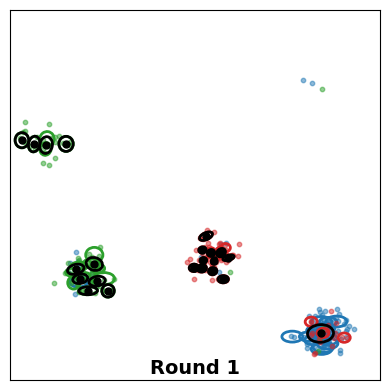

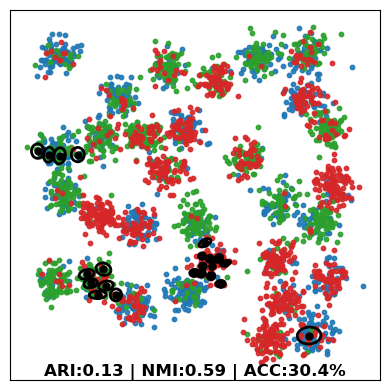

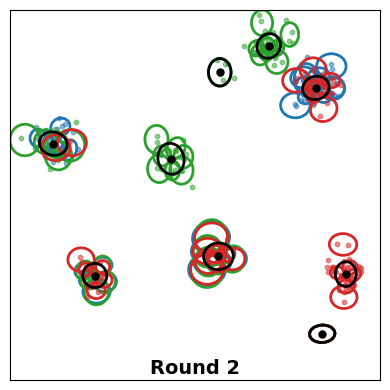

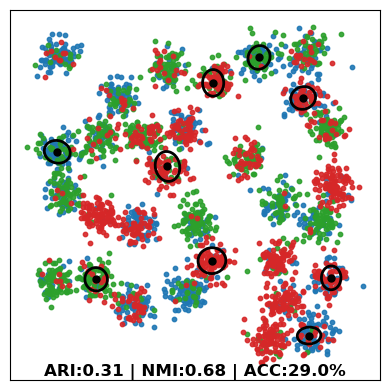

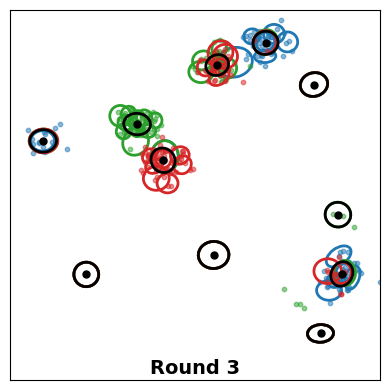

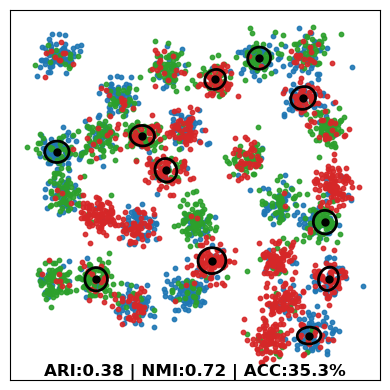

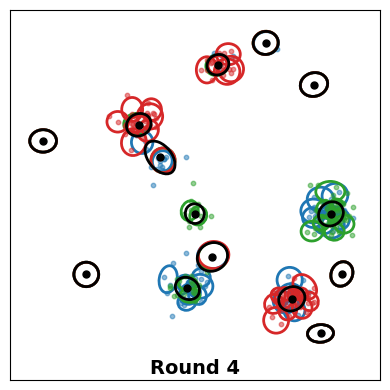

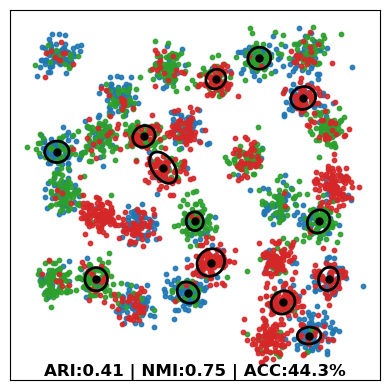

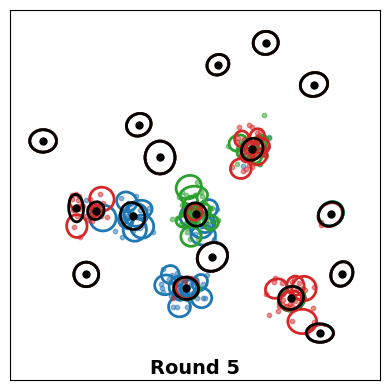

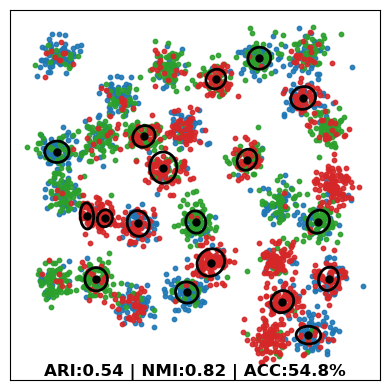

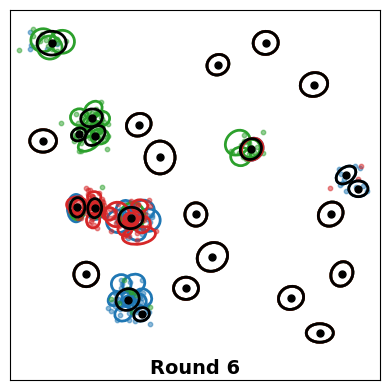

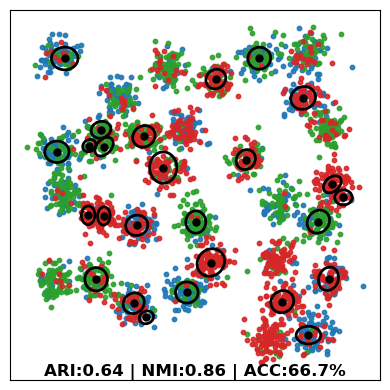

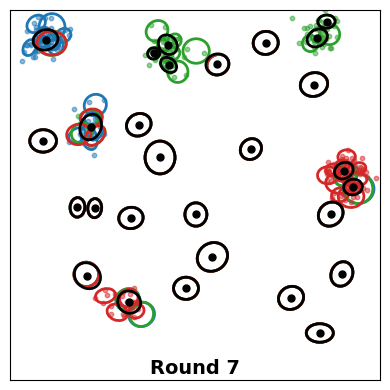

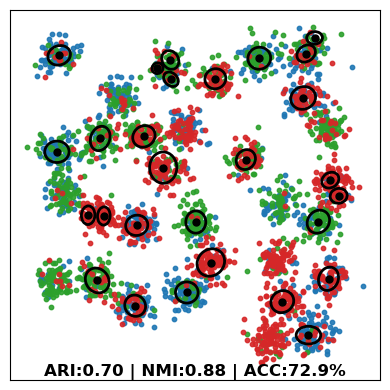

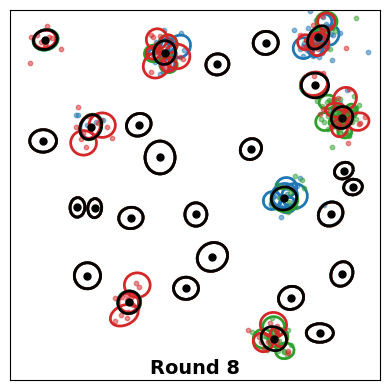

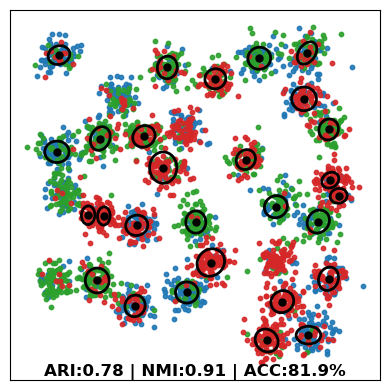

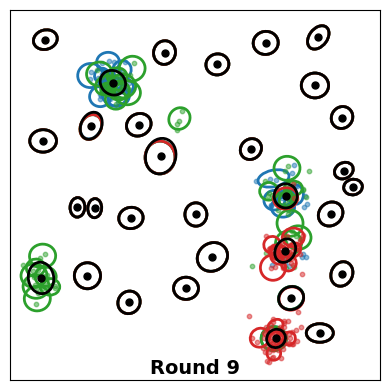

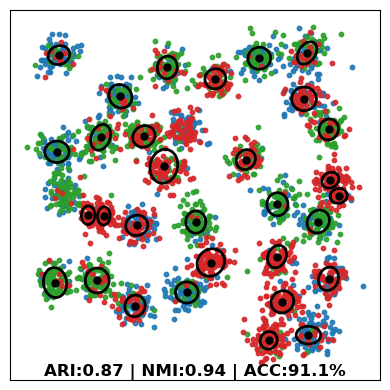

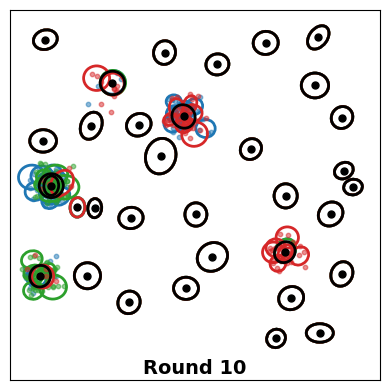

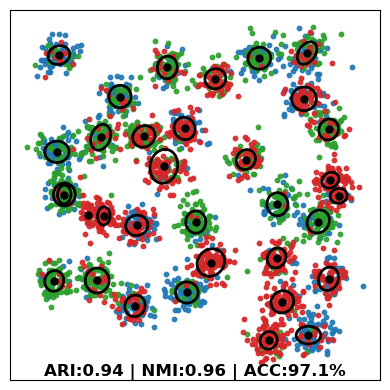

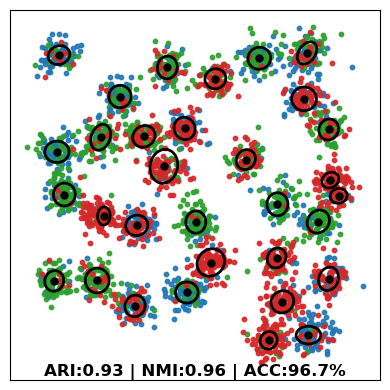

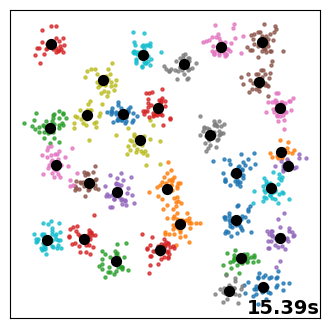

Round results saved to .Results/Streaming/D31_BeFedG_CPU_experiment_1_round_results.csv
BeFedG_CPU Accuracy - Mean: 0.9671, Std: 0.0000
BeFedG_CPU nmi - Mean: 0.9579, Std: 0.0000
BeFedG_CPU ari - Mean: 0.9337, Std: 0.0000
BeFedG_CPU time - Mean: 15.3859, Std: 0.0000
BeFedG_CPU clusters - Mean: 32.0000, Std: 0.0000


In [10]:

device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

df = pd.read_csv(".datasets/D31.txt", delimiter="\t", header=None)

X = torch.tensor(pd.get_dummies(df).values, dtype=torch.float32)[:,0:2]
X  = (X  - torch.min(X, dim=0)[0]) / (torch.max(X, dim=0)[0] - torch.min(X, dim=0)[0])
#X = (X - torch.mean(X, dim=0)) / torch.std(X, dim=0)

y = torch.tensor(pd.get_dummies(df).values, dtype=torch.float32)[:,2]
y = torch.tensor(y-1, dtype=torch.int64).squeeze()
num_clusters = len(np.unique(y))

feature_dim = X.shape[1]
num_classes = 1

batch_size = int(np.ceil(len(y)/num_clients/rounds/10))

print("D31",
      f"\n Samples:   {X.shape[0]}",
      f"\n Features:  {feature_dim}",
      f"\n classes:   {num_classes}")

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": np.sqrt(feature_dim),
    "kappa_join": 0.9,
    "N_r": 31,
    "c_max": batch_size,
    "kappa_features": 0.0,
    "device": device,
     "thr_relevance": 0.99
}
federated_model_params = local_model_params

if 1:
    run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size,
                             feature_dim, num_clients,  profiler_flag=False, debug_flag=0, 
                             unlabeled=1, name="D31", flag_noniid=True, flag_plot=True, flag_legend=False, non_iid_alpha=0.5)

skewed 
 Samples:   1000 
 Features:  2 
 classes:   1
Experiment 1.
 Test total number of samples in train dataset 1000


 BeFedG (CPU):
Round 1 starting...
Number of clusters in federated model: 8
ARI: 0.4919202529120247
NMI: 0.6329150707713902
ACC: 0.615
{'ARI': 0.4919202529120247, 'NMI': 0.6329150707713902, 'ACC': 0.615}
Round 2 starting...
Number of clusters in federated model: 9
ARI: 0.4488733494651094
NMI: 0.6160812636970407
ACC: 0.67
{'ARI': 0.4488733494651094, 'NMI': 0.6160812636970407, 'ACC': 0.67}
Round 3 starting...
Number of clusters in federated model: 9
ARI: 0.4327375977688801
NMI: 0.6551381160659531
ACC: 0.636
{'ARI': 0.4327375977688801, 'NMI': 0.6551381160659531, 'ACC': 0.636}
Round 4 starting...
Number of clusters in federated model: 6
ARI: 0.5357119197893517
NMI: 0.7814965183404328
ACC: 0.666
{'ARI': 0.5357119197893517, 'NMI': 0.7814965183404328, 'ACC': 0.666}
Round 5 starting...
Number of clusters in federated model: 5
ARI: 0.6509495728217874
NMI: 0.8111034277439907

c:\Users\Miha\OneDrive - Univerza v Ljubljani (1)\Dogodki\eFedG\utils\utils_plots.py:1074: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))  # Keep the figure size exactly the same


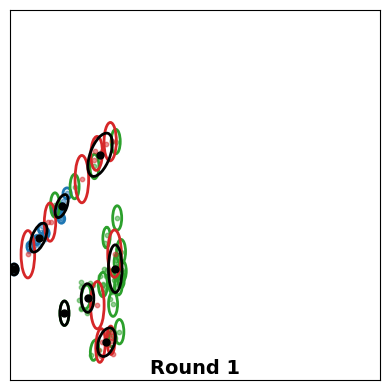

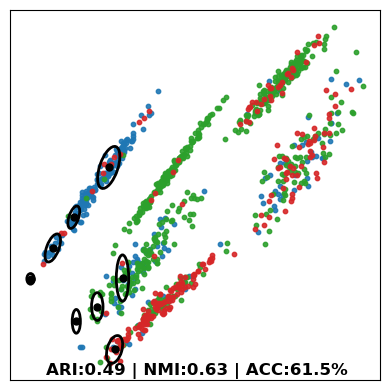

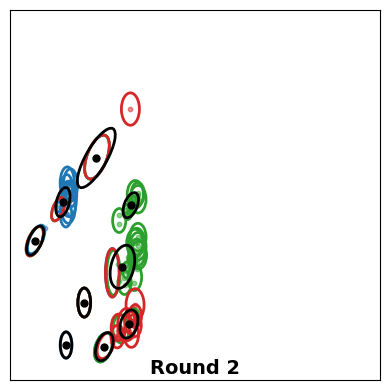

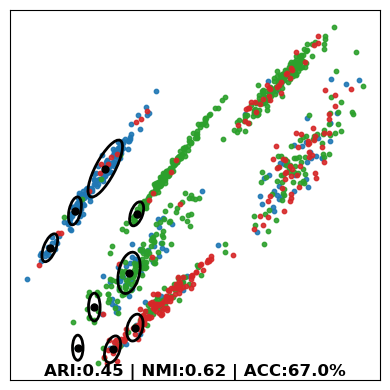

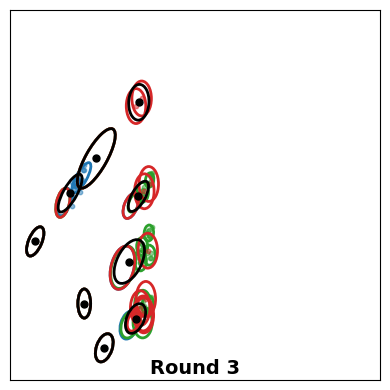

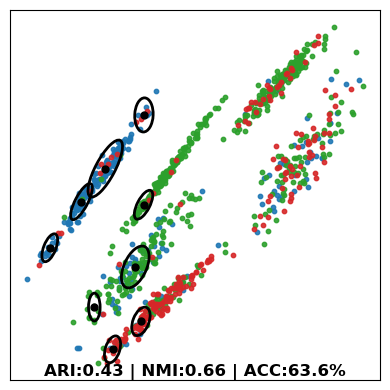

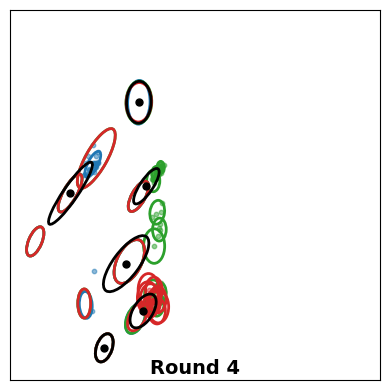

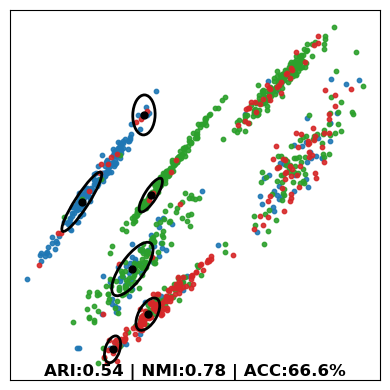

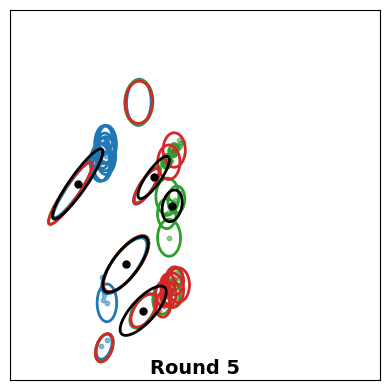

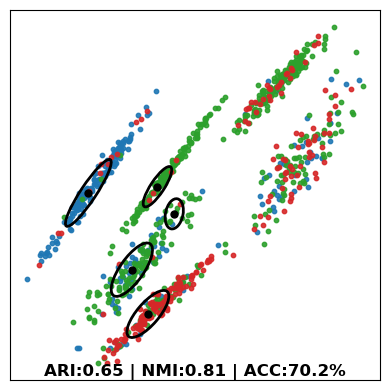

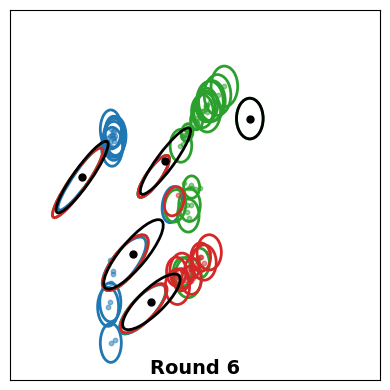

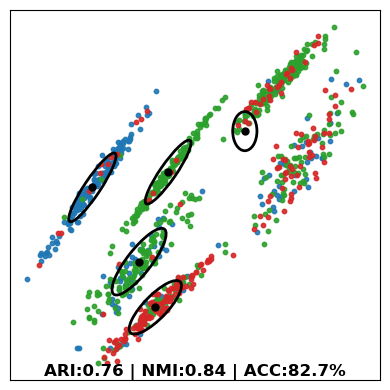

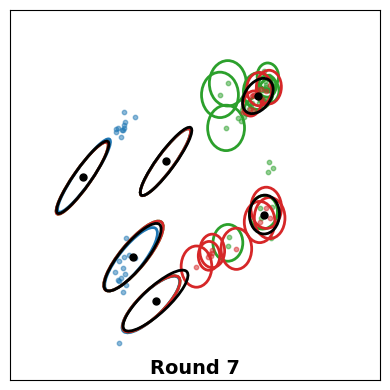

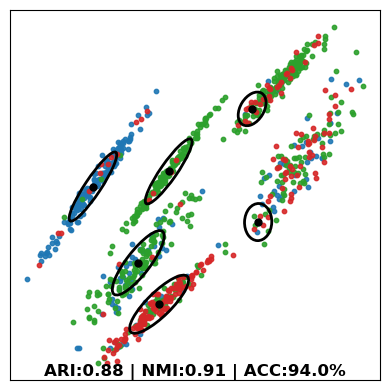

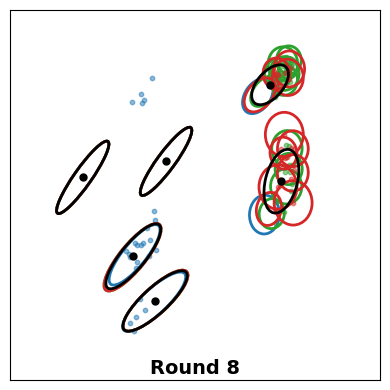

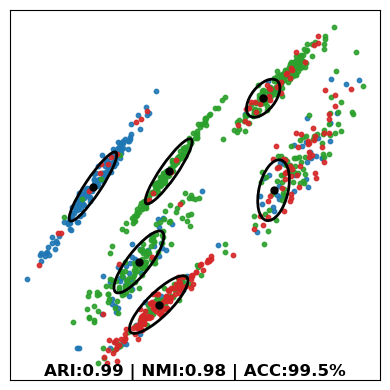

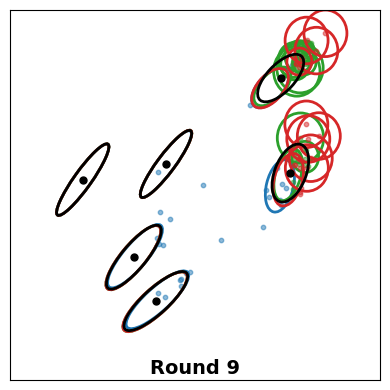

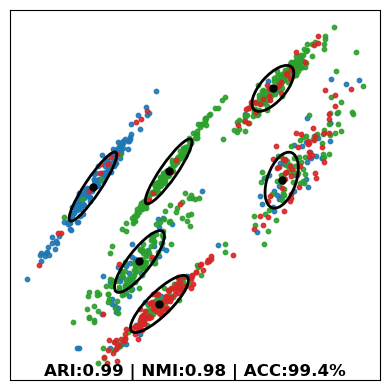

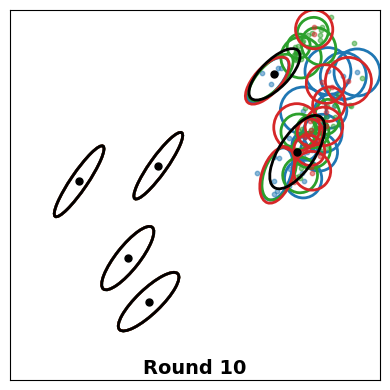

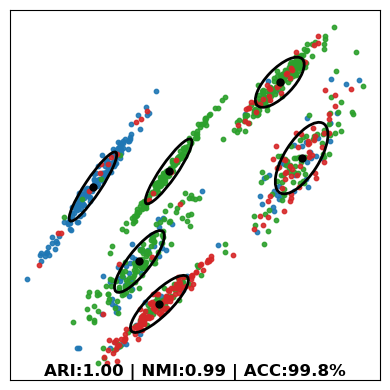

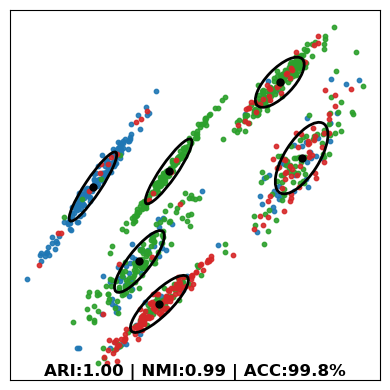

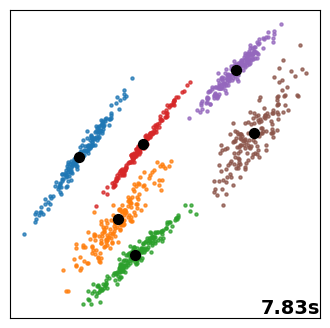

Round results saved to .Results/Streaming/Skewed_BeFedG_CPU_experiment_1_round_results.csv
BeFedG_CPU Accuracy - Mean: 0.9980, Std: 0.0000
BeFedG_CPU nmi - Mean: 0.9932, Std: 0.0000
BeFedG_CPU ari - Mean: 0.9953, Std: 0.0000
BeFedG_CPU time - Mean: 7.8302, Std: 0.0000
BeFedG_CPU clusters - Mean: 6.0000, Std: 0.0000


In [17]:
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

df_x = pd.read_csv(".datasets/skewed.txt", delimiter=" ", header=None, engine='python')
df_y = pd.read_csv(".datasets/skewed.pa", delimiter=" ", header=None, skiprows=4, engine='python')

X = df_x.values
y = df_y.values 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y-1, dtype=torch.int64).squeeze()

feature_dim = X.shape[1]
num_classes = 1
num_clients = 3

batch_size = int(np.ceil(len(y)/num_clients/10))

print("skewed",
      f"\n Samples:   {X.shape[0]}",
      f"\n Features:  {feature_dim}",
      f"\n classes:   {num_classes}")

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": np.sqrt(feature_dim),
    "kappa_join": 0.5,
    "N_r": 6,
    "c_max": batch_size,
    "kappa_features": 0.0,
    "device": device,
    "thr_relevance": 1
}
federated_model_params = local_model_params


if 1:
    run_benchmark_experiment(X, y, local_model_params, federated_model_params, batch_size, 
                             feature_dim, num_clients, profiler_flag=False, debug_flag=0,
                             unlabeled=1, name="Skewed", flag_noniid=False, flag_plot=True, flag_legend=False, non_iid_alpha=0.5, flag_sort=True)

In [12]:
from pathlib import Path
import shutil, requests, kagglehub
#pip install -U kagglehub

from pathlib import Path
import requests

def download_file(url, local_path, overwrite=False, timeout=30):
    local_path = Path(local_path)

    if local_path.exists() and not overwrite:
        print(f"Skip: {local_path} already exists.")
        return local_path

    local_path.parent.mkdir(parents=True, exist_ok=True)
    tmp_path = local_path.with_suffix(local_path.suffix + ".part")

    with requests.get(url, stream=True, timeout=timeout) as r:
        r.raise_for_status()
        with open(tmp_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

    tmp_path.replace(local_path)
    return local_path

url = "http://205.174.165.80/CICDataset/CIC-IDS-2017"
local_filename = Path(".datasets") / "CIC-IDS-2017" 
download_file(url, local_filename)


dest_dir = Path(".datasets/NLS_KDD")
dest_dir.mkdir(parents=True, exist_ok=True)
dest_file = dest_dir / "KDDTrain+.arff"

if not dest_file.exists():
    dl_root = Path(kagglehub.dataset_download("hassan06/nslkdd"))  # requires Kaggle API creds
    found = None
    for p in dl_root.rglob("*"):
        if p.name.lower() == "kddtrain+.arff":
            found = p
            break
    if found is None:
        url = "https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/master/KDDTrain%2B.arff"
        tmp = dest_file.with_suffix(".arff.part")
        with requests.get(url, stream=True, timeout=120) as r:
            r.raise_for_status()
            with open(tmp, "wb") as f:
                for chunk in r.iter_content(1 << 20):
                    if chunk: f.write(chunk)
        tmp.replace(dest_file)
        print(f"Downloaded from mirror to: {dest_file}")
    else:
        shutil.copy2(found, dest_file)
        print(f"Copied from Kaggle cache: {dest_file}")
else:
    print(f"Already present: {dest_file}")


Skip: .datasets\CIC-IDS-2017 already exists.
Already present: .datasets\NLS_KDD\KDDTrain+.arff


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import torch
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from pathlib import Path
import re

base_dir = Path(".datasets/NLS_KDD")
base_dir.mkdir(parents=True, exist_ok=True)

components_list = [5, 10, 100, 126]
x_paths = {n: base_dir / f"X_pca_{n}_features.pt" for n in components_list}
y_path = base_dir / "y_labels.pt"

need_components = [n for n, p in x_paths.items() if not p.exists()]
need_labels = not y_path.exists()

if not need_components and not need_labels:
    print("All outputs already exist. Nothing to do.")
else:
    def sanitize_arff_nominals(src, dst=None):
        src = Path(src)
        txt = src.read_text(encoding="utf-8", errors="ignore")
        pat = re.compile(r'(^\s*@\s*attribute\b[^{]*\{)([^}]*)\}', re.IGNORECASE | re.MULTILINE)
        def repl(m):
            head, body = m.group(1), m.group(2)
            toks = [t.strip() for t in body.split(",") if t.strip()]
            clean = []
            for t in toks:
                if (len(t) >= 2) and (t[0] == t[-1]) and t[0] in ("'", '"'):
                    t = t[1:-1]
                clean.append(t.strip())
            return head + ",".join(clean) + "}"
        out = pat.sub(repl, txt)
        if dst is None:
            dst = src.with_suffix(".cleaned.arff")
        Path(dst).write_text(out, encoding="utf-8")
        return str(dst)

    arff_src = base_dir / "KDDTrain+.arff"
    arff_clean = arff_src.with_suffix(".cleaned.arff")
    if not arff_clean.exists():
        if not arff_src.exists():
            raise FileNotFoundError(f"Missing ARFF: {arff_src}")
        arff_clean = Path(sanitize_arff_nominals(arff_src))

    data, meta = arff.loadarff(str(arff_clean))
    df = pd.DataFrame(data)
    for col in df.select_dtypes([object]).columns:
        df[col] = df[col].str.decode("utf-8")

    y = df.pop("class")

    numeric_types = {"numeric", "real", "integer"}
    numerical_cols = [c for c in df.columns if str(meta[c][0]).lower() in numeric_types]
    categorical_cols = [c for c in df.columns if c not in numerical_cols]

    try:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    except TypeError:
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", ohe, categorical_cols),
        ],
        remainder="passthrough",
    )

    if need_components:
        df_transformed = preprocessor.fit_transform(df)
        print("Number of features after one-hot encoding and scaling, before PCA:", df_transformed.shape[1])

        for n_components in need_components:
            print(f"Performing PCA with {n_components} components")
            pca = PCA(n_components=n_components)
            pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("pca", pca),
            ])
            X_reduced = pipeline.fit_transform(df, y)
            X_tensor = torch.tensor(X_reduced, dtype=torch.float32)
            torch.save(X_tensor, x_paths[n_components])
            print(f"Saved X with {n_components} components to '{x_paths[n_components]}'")
    else:
        print("All PCA feature files already exist; skipping PCA.")

    if need_labels:
        y_cleaned = y.astype(str).str.strip().str.lower()
        y_binary = y_cleaned.apply(lambda label: 0 if label == "normal" else 1)
        y_tensor = torch.tensor(y_binary.values, dtype=torch.int64)
        torch.save(y_tensor, y_path)
        print(f"Saved target labels to '{y_path}'")
    else:
        print("Label file already exists; skipping labels.")


All outputs already exist. Nothing to do.


In [14]:
from scipy.io import arff
import pandas as pd

data, meta = arff.loadarff(".datasets/NLS_KDD/KDDTrain+.cleaned.arff")
columns = list(meta.names())
df = pd.DataFrame(data, columns=columns)

print(f"{len(columns)} columns:")
for i, col in enumerate(columns, 1):
    print(f"{i:2d}: {col}")

42 columns:
 1: duration
 2: protocol_type
 3: service
 4: flag
 5: src_bytes
 6: dst_bytes
 7: land
 8: wrong_fragment
 9: urgent
10: hot
11: num_failed_logins
12: logged_in
13: num_compromised
14: root_shell
15: su_attempted
16: num_root
17: num_file_creations
18: num_shells
19: num_access_files
20: num_outbound_cmds
21: is_host_login
22: is_guest_login
23: count
24: srv_count
25: serror_rate
26: srv_serror_rate
27: rerror_rate
28: srv_rerror_rate
29: same_srv_rate
30: diff_srv_rate
31: srv_diff_host_rate
32: dst_host_count
33: dst_host_srv_count
34: dst_host_same_srv_rate
35: dst_host_diff_srv_rate
36: dst_host_same_src_port_rate
37: dst_host_srv_diff_host_rate
38: dst_host_serror_rate
39: dst_host_srv_serror_rate
40: dst_host_rerror_rate
41: dst_host_srv_rerror_rate
42: class


In [15]:
import torch

def load_data(selection):
    files = {
        5: '.datasets/NLS_KDD/X_pca_5_features.pt',
        10: '.datasets/NLS_KDD/X_pca_10_features.pt',
        100: '.datasets/NLS_KDD/X_pca_100_features.pt',
        126: '.datasets/NLS_KDD/X_pca_126_features.pt',
        'labels': '.datasets/NLS_KDD/y_labels.pt'
    }

    if selection in files:
        return torch.load(files[selection])
    else:
         raise ValueError(f"Invalid selection: {selection}")

if 0: 
    #Just a test to see if it works fine
    feature_dim = 100
    X = load_data(feature_dim) 
    y = load_data('labels') 

    means = X.mean(dim=0) 
    variances = X.var(dim=0, unbiased=False) 
    print("Means of each feature:", means)
    print("Variances of each feature:", variances)
    unique_labels, counts = torch.unique(y, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f'Count for label {label.item()}: {count.item()}')
        

Experiment Configuration: 
 Samples:   125973 
 Features:  5 
 Classes:   1
Experiment 1.
 Test total number of samples in train dataset 125973


 BeFedG (CPU):
Round 1 starting...
Number of clusters in federated model: 116
ARI: 0.7842107054059603
NMI: 0.6842287671773088
ACC: 0.9427813896628643
{'ARI': 0.7842107054059603, 'NMI': 0.6842287671773088, 'ACC': 0.9427813896628643}
Round 2 starting...
Number of clusters in federated model: 120
ARI: 0.24265511022954098
NMI: 0.2658965699120207
ACC: 0.7468028863327856
{'ARI': 0.24265511022954098, 'NMI': 0.2658965699120207, 'ACC': 0.7468028863327856}
Round 3 starting...
Number of clusters in federated model: 110
ARI: 0.23585085933661087
NMI: 0.26324491495447555
ACC: 0.7433577036349059
{'ARI': 0.23585085933661087, 'NMI': 0.26324491495447555, 'ACC': 0.7433577036349059}
Round 4 starting...
Number of clusters in federated model: 119
ARI: 0.16543184400368793
NMI: 0.1849329543060053
ACC: 0.7041747041032602
{'ARI': 0.16543184400368793, 'NMI': 0.18493295

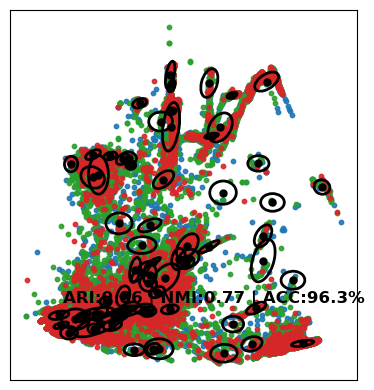

In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

import torch

def load_data(selection):

    files = {
        5: '.datasets/NLS_KDD/X_pca_5_features.pt',
        10: '.datasets/NLS_KDD/X_pca_10_features.pt',
        100: '.datasets/NLS_KDD/X_pca_100_features.pt',
        126: '.datasets/NLS_KDD/X_pca_126_features.pt',
        'labels': '.datasets/NLS_KDD/y_labels.pt'
    }
    
    file_path = files.get(selection)
    if file_path:
        try:
            return torch.load(file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"The file for selection {selection} could not be found at {file_path}")
    else:
        raise ValueError(f"Invalid selection: {selection}. Available selections are: {list(files.keys())}")


feature_dim = 5
X = load_data(feature_dim) 
y = load_data('labels')
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)

num_classes = 1
num_clients = 3
num_repetitions = 1
batch_size = int(np.ceil(len(y) / num_clients / 10))

print("Experiment Configuration:",
      f"\n Samples:   {X.shape[0]}",
      f"\n Features:  {feature_dim}",
      f"\n Classes:   {num_classes}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model configuration parameters
local_model_params = {
    "feature_dim": feature_dim,  # Dimension of input features
    "num_classes": num_classes,  # Number of classes (currently 1 as placeholder)
    "kappa_n": 2,                # Parameter for local model updates
    "num_sigma": np.sqrt(feature_dim),  # Sigma parameter based on feature dimension
    "kappa_join": 0.7,           # Factor controlling the joining threshold
    "N_r": 16,          # Radius parameter or threshold count
    "c_max": batch_size,         # Max capacity for clusters
    "kappa_features": 0.0,       # Placeholder for feature scaling factor
    "device": device,            # Computation device
    "thr_relevance": 1 # Threshold relevance score
}

# Copy local parameters to federated model
federated_model_params = local_model_params

if 1:

    run_benchmark_experiment(
        X, y, 
        local_model_params, federated_model_params, 
        batch_size=batch_size, feature_dim=feature_dim, 
        num_clients=num_clients, profiler_flag=False, debug_flag=0,
        unlabeled=1, name="NLS-KDD", flag_noniid=False, 
        flag_plot=False, flag_legend=False, 
        non_iid_alpha=1, flag_sort=False
    )
